In [1]:
from collections import Counter

from preprocessing import preprocess
import plotly.express as px
import pandas as pd
from pathlib import Path
from Bio import SeqIO
import matplotlib.pyplot as plt
from itertools import pairwise

In [14]:
datasets = {
    str(filename): list(SeqIO.parse(filename, format="fasta"))
    for filename in Path("../data/raw").glob("*.fasta")
}
datasets = {
    f'{filename}_{len(bin_[0])}': bin_ for filename, genes in datasets.items() for bin_ in preprocess(list(genes), bin_width=200, min_bin_size=60) 
}

In [15]:
[len(bin_) for bin_ in datasets.values()]

[80,
 126,
 79,
 134,
 80,
 451,
 938,
 347,
 722,
 1205,
 274,
 222,
 776,
 1150,
 1018,
 873,
 68,
 252,
 149,
 142,
 93,
 102,
 76]

In [16]:
df = pd.DataFrame.from_records(
    [
        (filename, len(gene.seq))
        for filename, genes in datasets.items()
        for gene in genes
    ],
    columns=["filename", "gene_length"],
)

px.box(df, color="filename", x="gene_length")

In [18]:
records = []
for filename, genes in datasets.items():
    all_nucs = "".join(str(gene.seq) for gene in genes)
    counts = Counter(all_nucs)
    for nuc, count in counts.items():
        records.append((filename.split("_")[0], nuc, count / len(all_nucs)))


df = pd.DataFrame.from_records(
    records, columns=["filename", "nucleotide", "Relative Frequency"]
)

px.bar(
    df,
    barmode="group",
    x="nucleotide",
    y="Relative Frequency",
    color="filename",
)

In [19]:
def kmerize(sequence: str, k=3):
    return [sequence[i : i + k] for i in range(len(sequence) - k)]


records = []
for filename, genes in datasets.items():
    all_kmers = [kmer for gene in genes for kmer in kmerize(str(gene.seq))]
    counts = Counter(all_kmers)
    for kmer, count in counts.items():
        records.append((filename, kmer, count / len(all_kmers)))


df = pd.DataFrame.from_records(
    records, columns=["filename", "kmer", "Relative Frequency"]
)

px.violin(
    df,
    violinmode="group",
    hover_name="kmer",
    y="Relative Frequency",
    color="filename",
    points="all",
)

In [ ]:
import ssw

In [22]:
for dataset_name, bin_ in datasets.items():
    path = Path(dataset_name)
    
    SeqIO.write(
        bin_,
        Path(f"../data/preprocessed/{path.name}"),
        format="fasta",
    )

In [ ]:
help(ssw.force_align)

Help on cython_function_or_method in module ssw.alignmentmgr:

force_align(read: 'STR_T', reference: 'STR_T', force_overhang: 'bool' = False, aligner: 'Optional[AlignmentMgr]' = None) -> 'Alignment'
    Enforces no gaps by raising the ``gap_open`` penalty
    
    Args:
        read: Read sequence python string or bytes-string
        reference: Reference sequence python string or bytes-string
        force_overhang: Make sure only one end overhangs
        aligner: pass an existing :class:`AlignmentMgr` object
    
    Returns:
        :class:`ssw.alignmenttuple.Alignment` result
    
    Raises:
        ValueError: No solution found
        ValueError: Read does not align to one overhang



In [ ]:
mgr = ssw.AlignmentMgr()
help(mgr.build_dna_score_matrix())

Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      True if self else False
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [38]:
aligned = list(SeqIO.parse("../data/random.fasta_1203", format="fasta"))


In [39]:
import numpy as np

matrix = np.array([np.array(list(gene.seq)) for gene in aligned])

In [40]:
matrix.shape

(76, 1844)

In [41]:
matrix[:, 10:20]

array([['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'

In [42]:
from collections import Counter

px.bar(
    pd.DataFrame.from_dict(
        Counter(Counter(column)["-"] for column in matrix.T), orient="index"
    )
)

In [45]:
lesser_sparsed_columns = [
    i
    for i, column in enumerate(matrix.T)
    if Counter(column)["-"] < len(column) * 0.75
]
denser_matrix = matrix.T[lesser_sparsed_columns].T

In [46]:
denser_matrix.shape

(76, 1370)

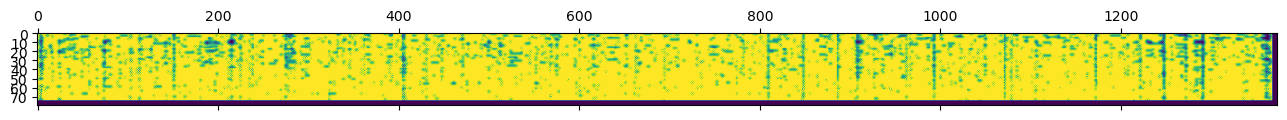

In [47]:
def average_neighborhood(matrix: np.ndarray):
    averaged = np.pad(np.zeros_like(matrix, dtype=np.float32), pad_width=(1, 1))
    for i in range(len(matrix) - 1):
        for j in range(len(matrix[i]) - 1):
            averaged[i, j] = (
                sum(
                    [
                        matrix[i, j + 1],
                        matrix[i, j - 1],
                        matrix[i + 1, j],
                        matrix[i - 1, j],
                    ]
                )
                / 4
            )
    return averaged


averaged = denser_matrix != "-"
for _ in range(2):
    averaged = average_neighborhood(averaged)

plt.matshow(averaged)

In [48]:
lesser_sparsed_columns

[0,
 1,
 4,
 5,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 52,
 53,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 130,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 175,
 176,
 177,
 178,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245

In [49]:
intervals = []

beginning = lesser_sparsed_columns[0]
for n, m in pairwise(lesser_sparsed_columns[1:]):
    if n == m - 1:
        continue
    else:
        intervals.append((beginning, n))
        beginning = m

In [50]:
cool_intervals = [(i, j) for i, j in intervals if i + 8 < j]

In [51]:
len(cool_intervals)

52

/var/folders/yd/l50vqmsx22sf5dgyz2cg_skr0000gn/T/ipykernel_7919/3265604970.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



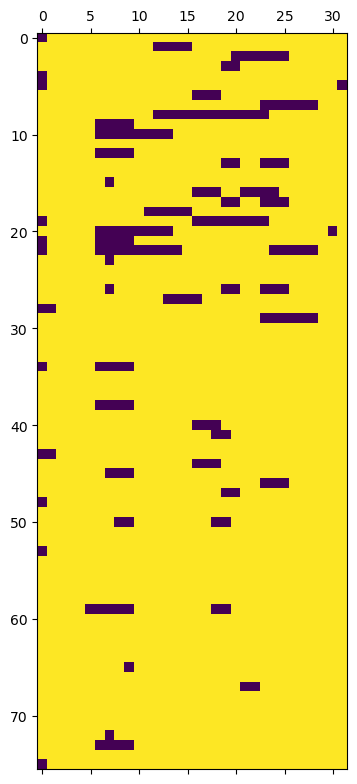

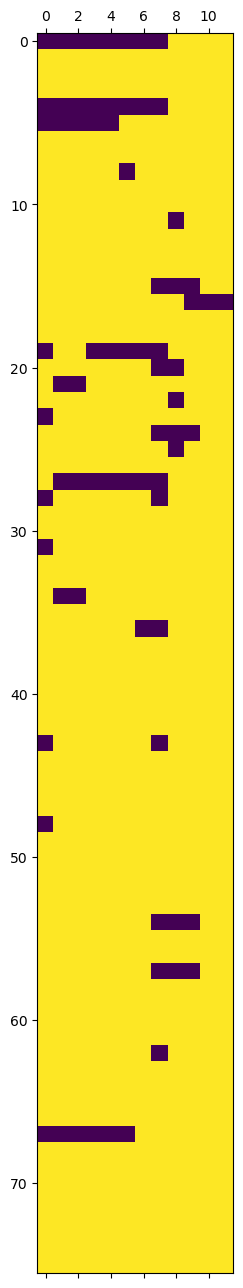

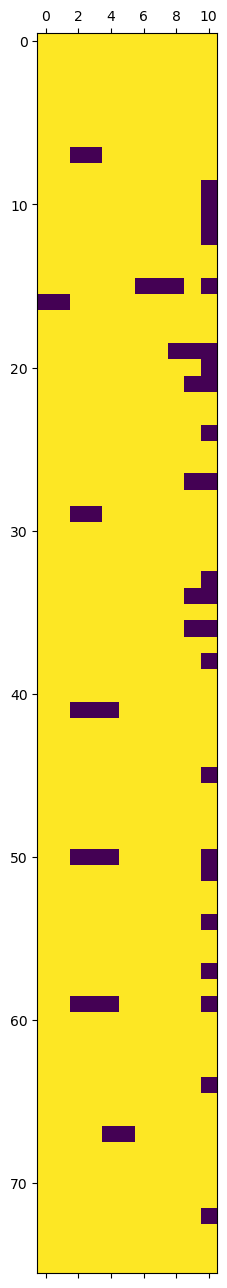

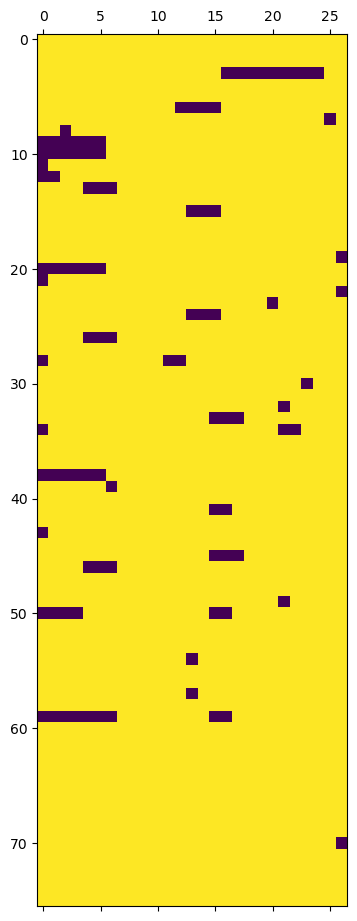

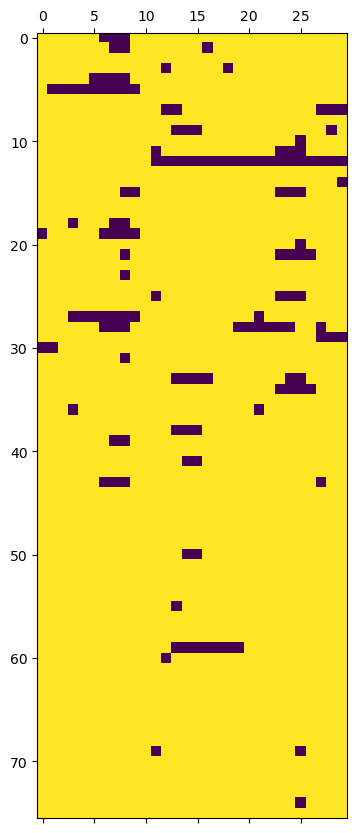

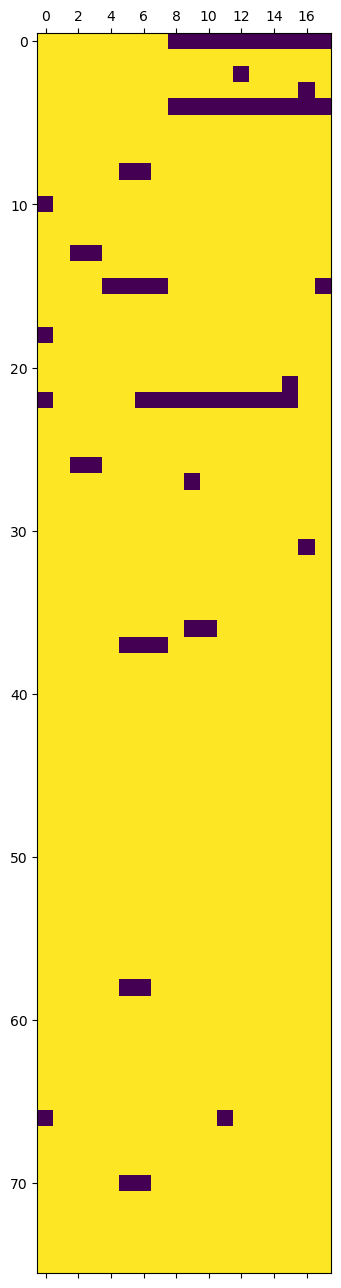

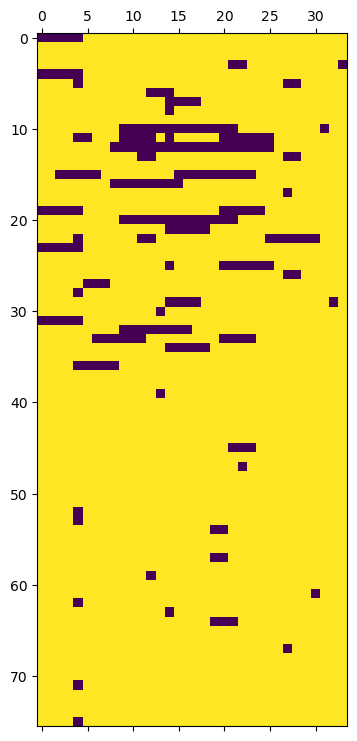

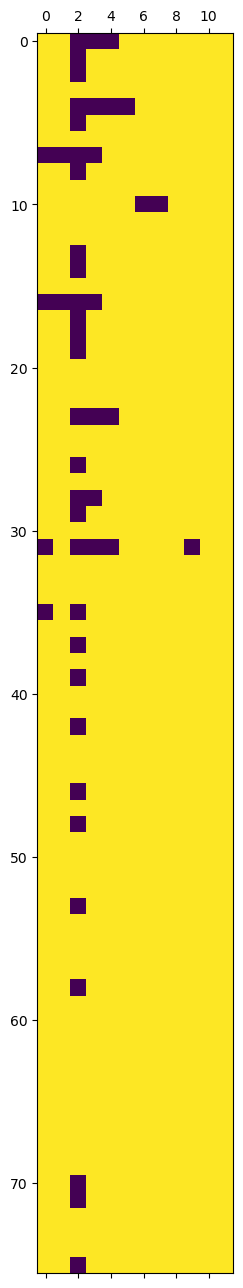

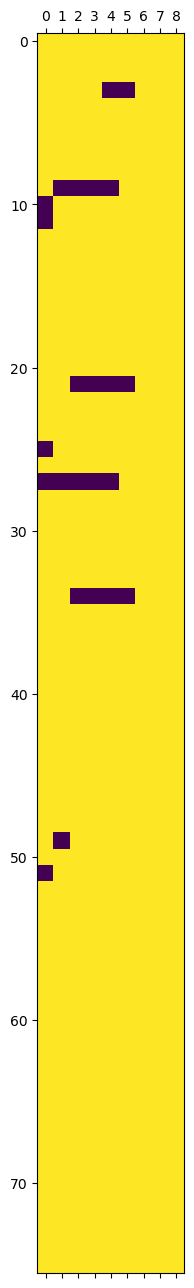

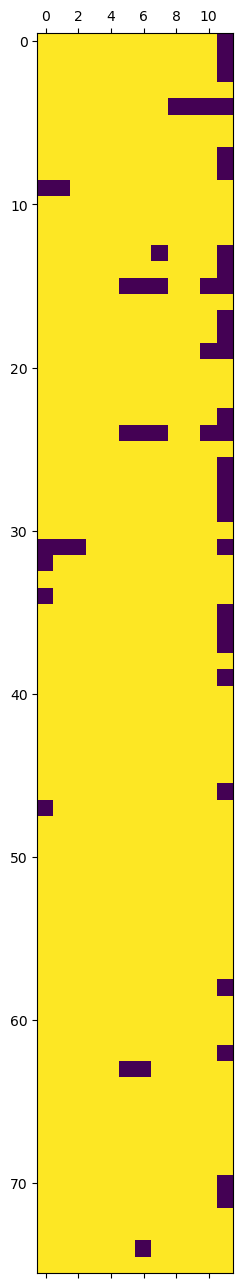

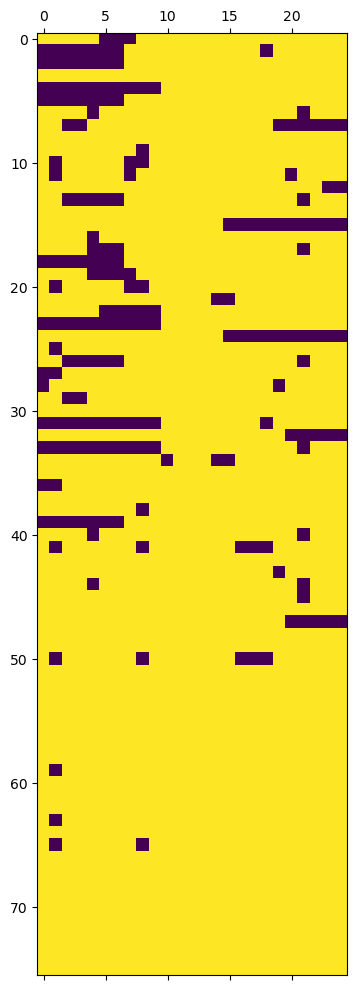

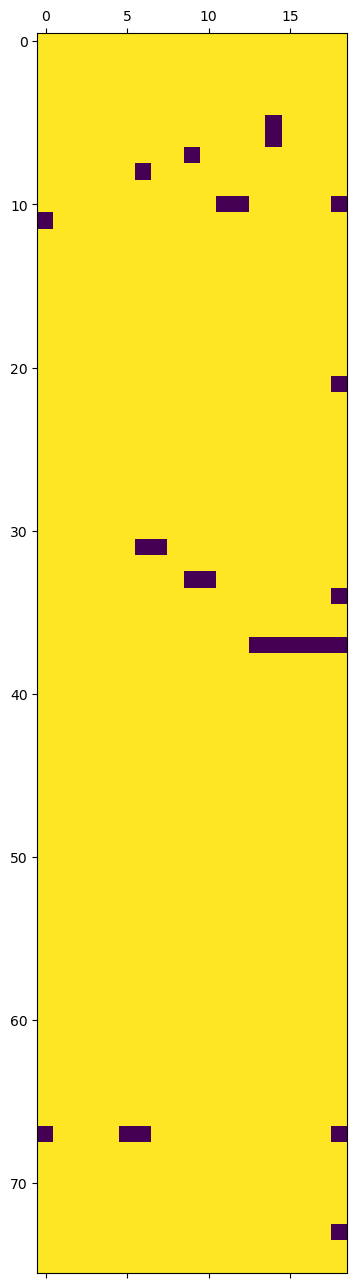

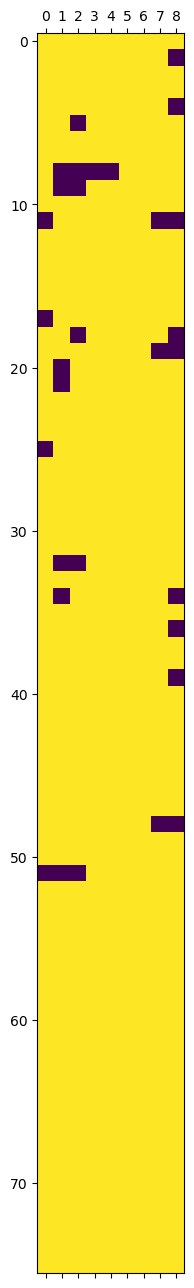

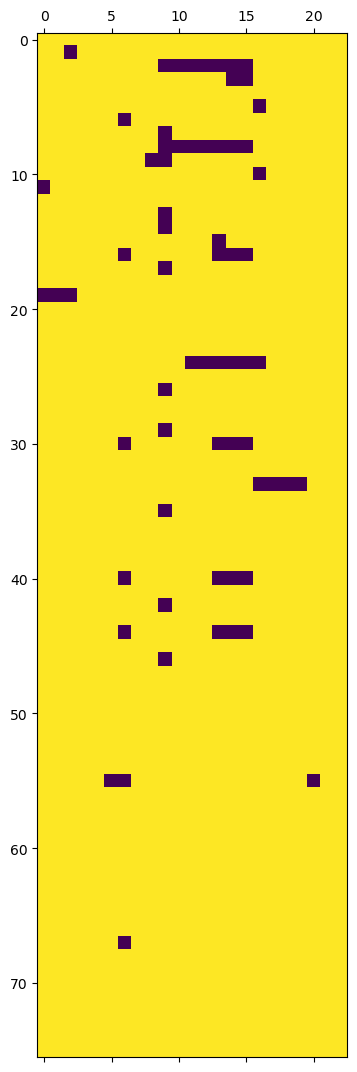

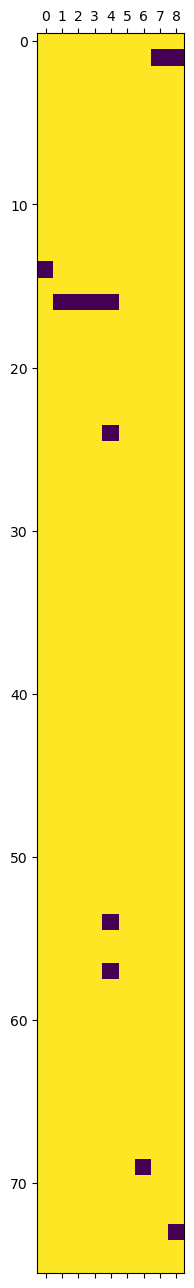

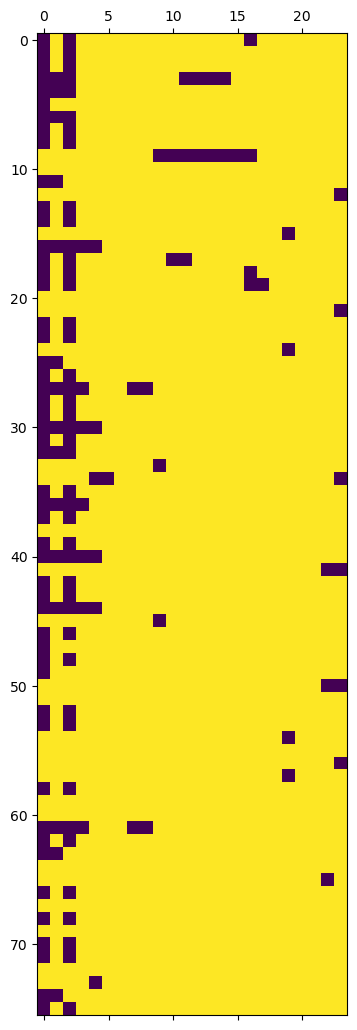

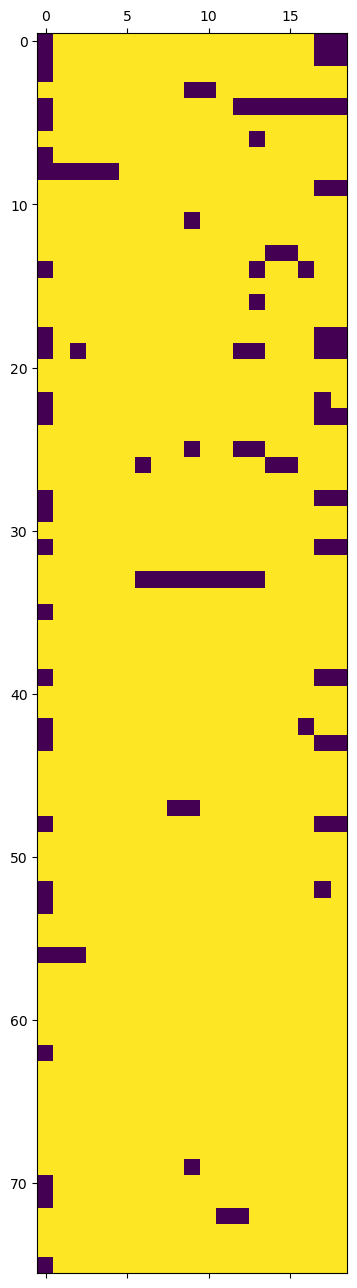

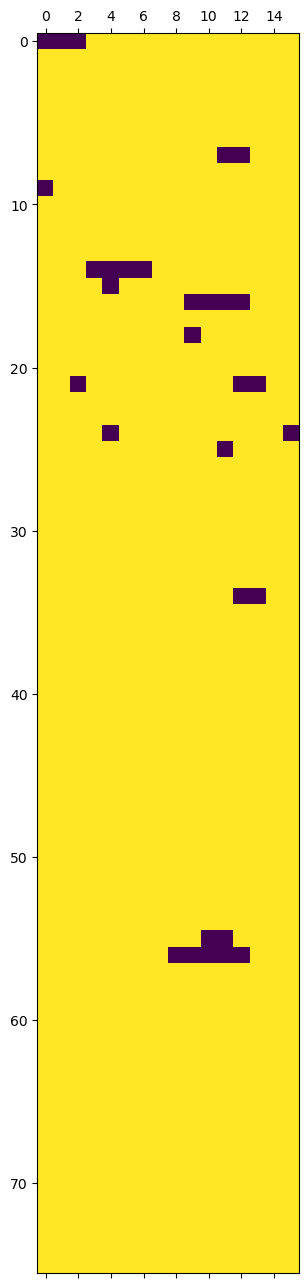

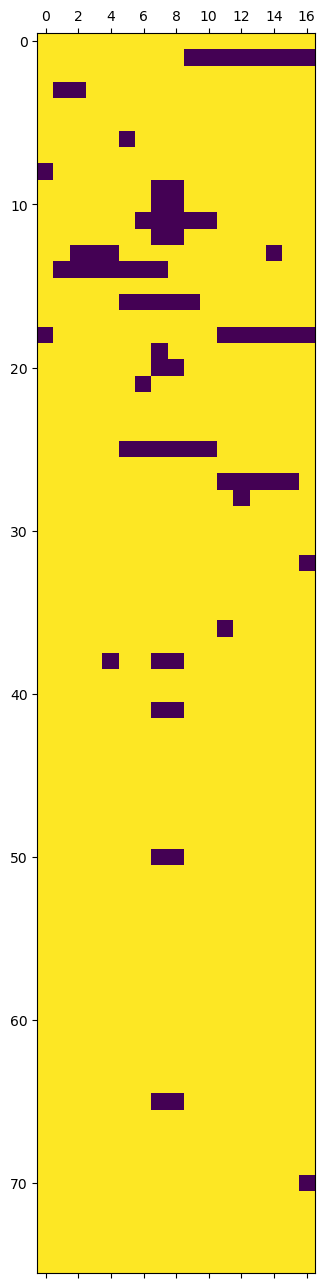

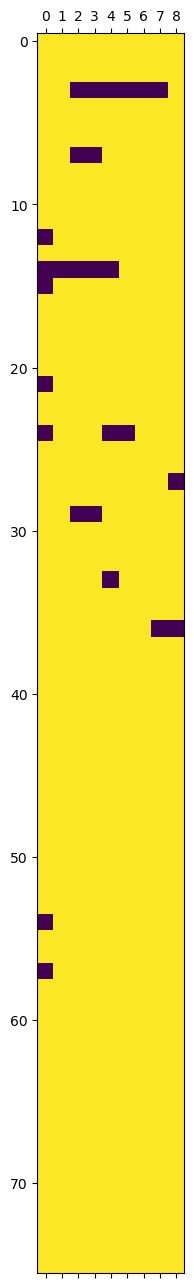

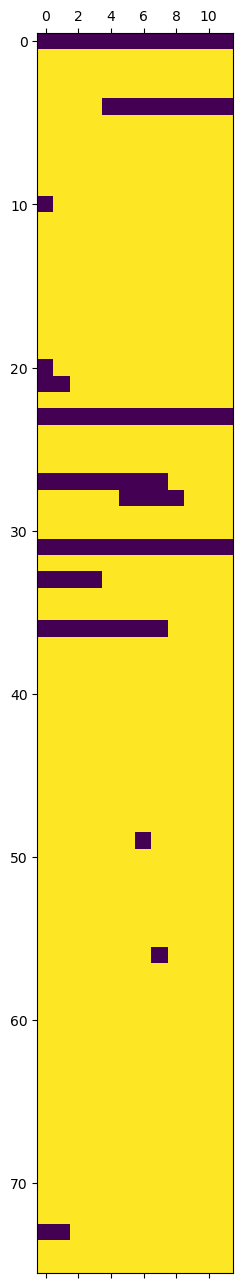

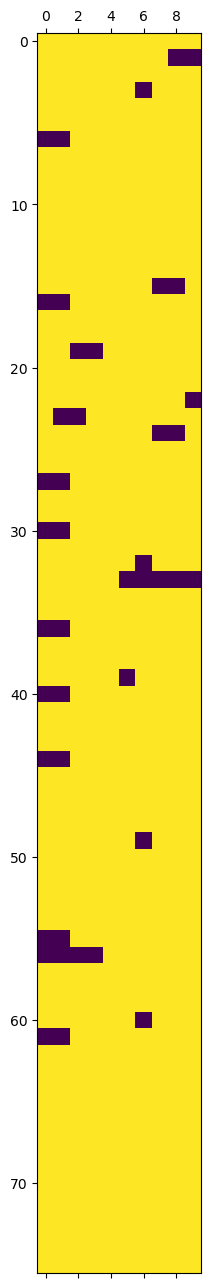

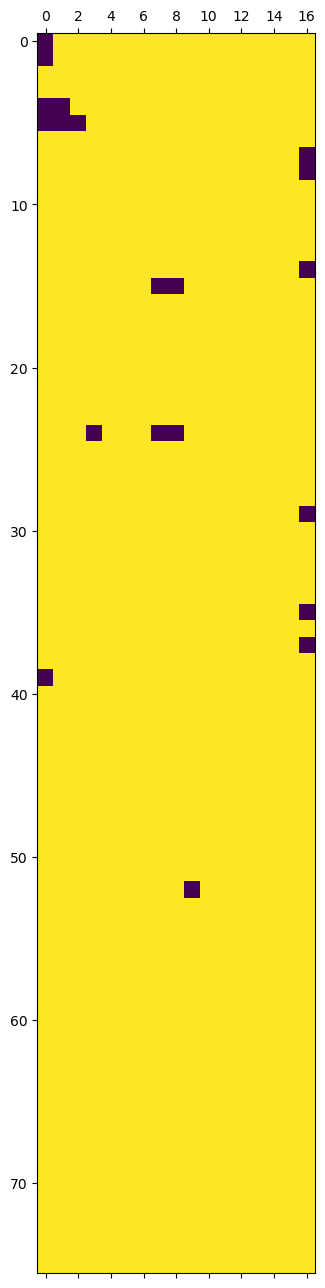

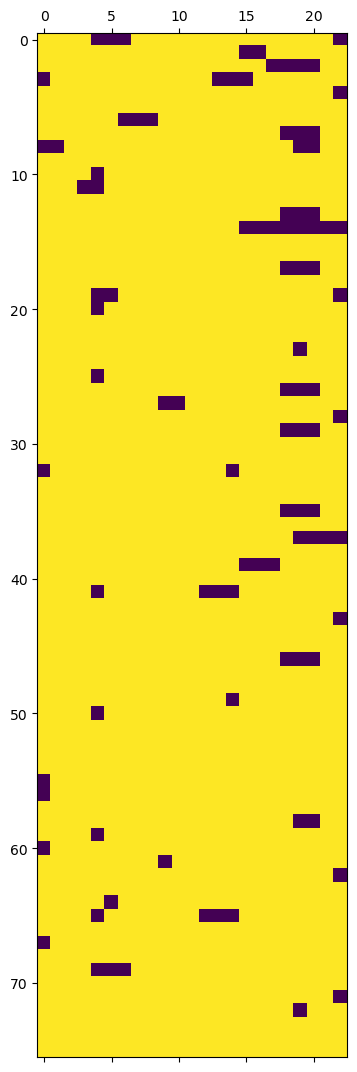

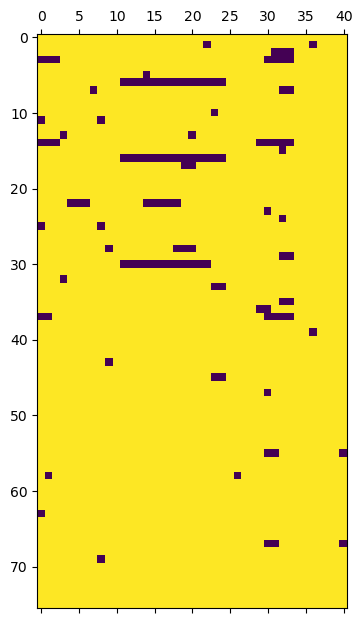

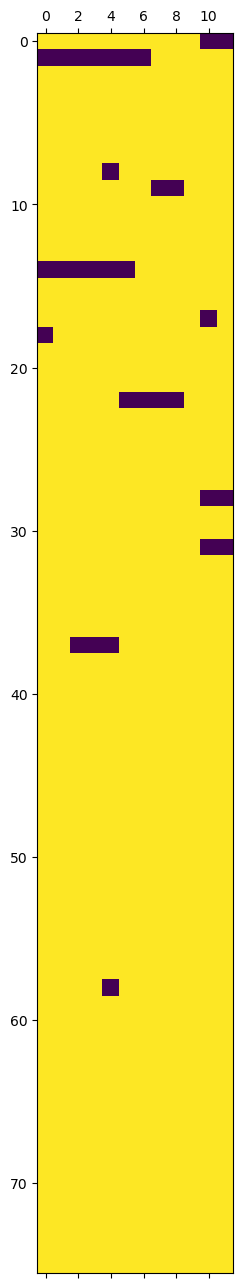

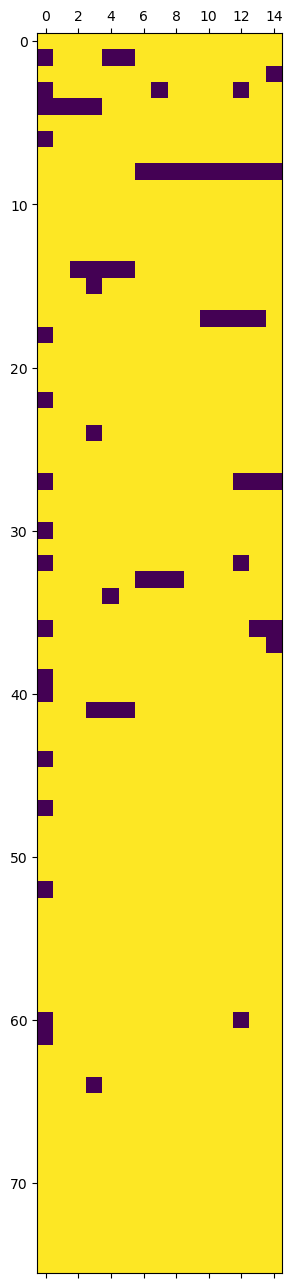

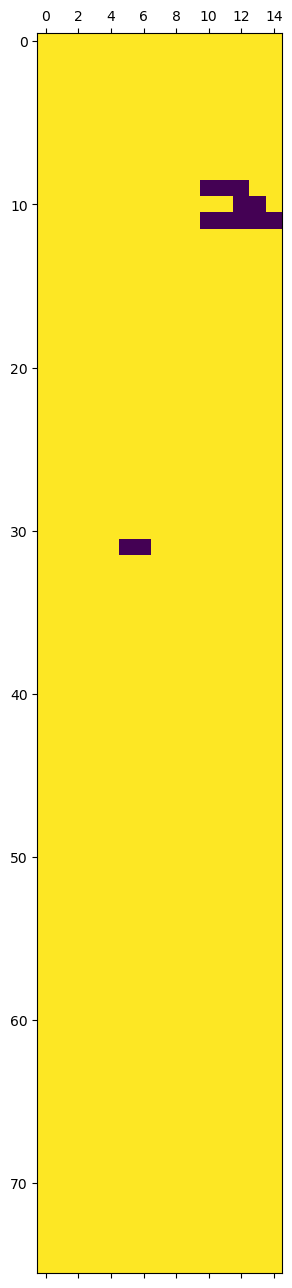

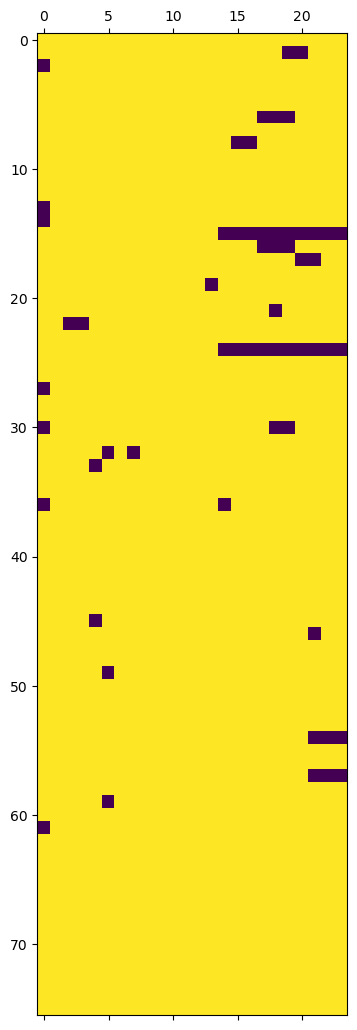

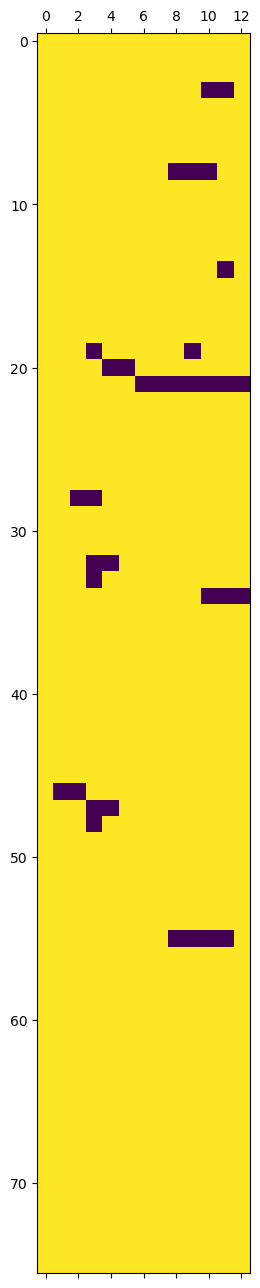

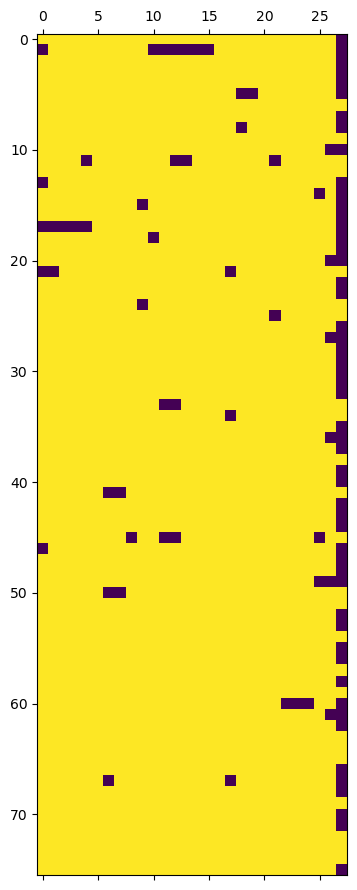

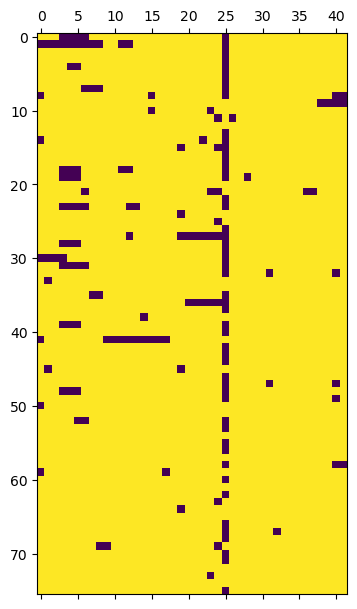

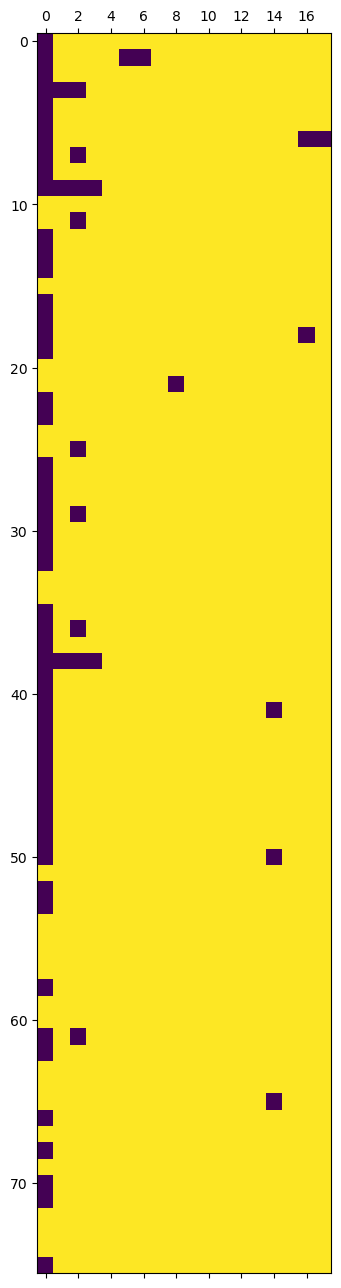

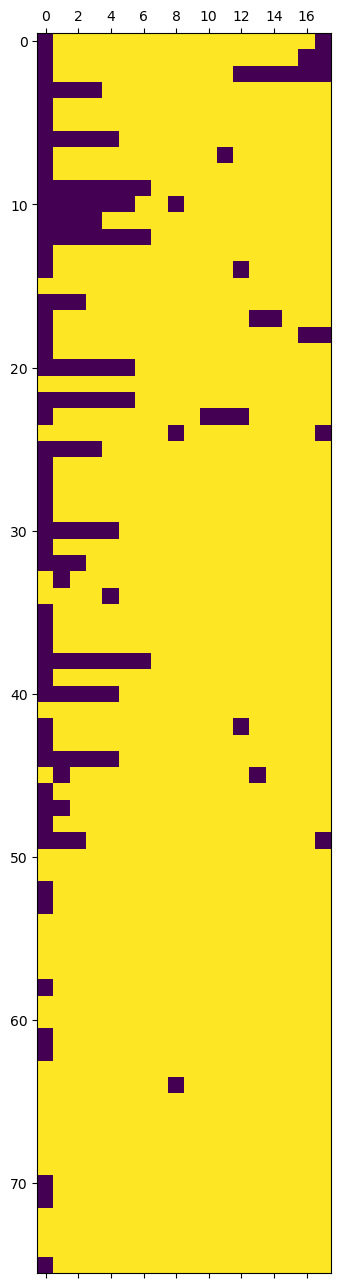

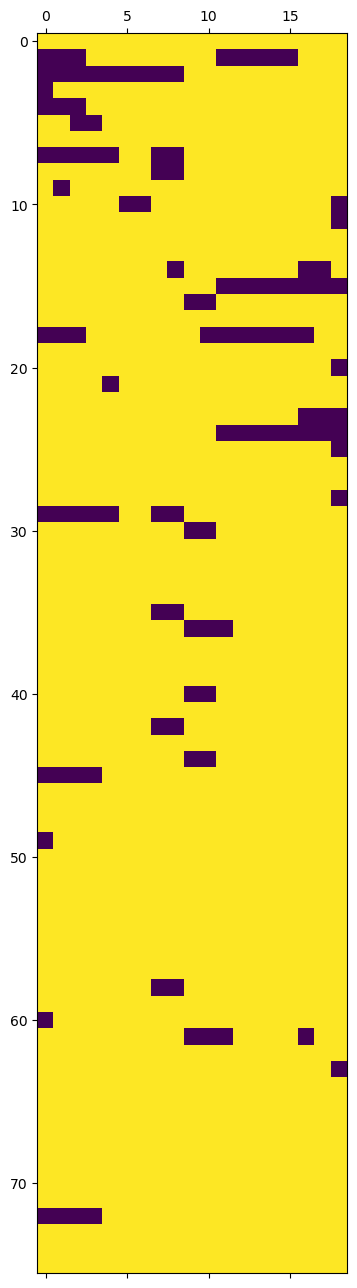

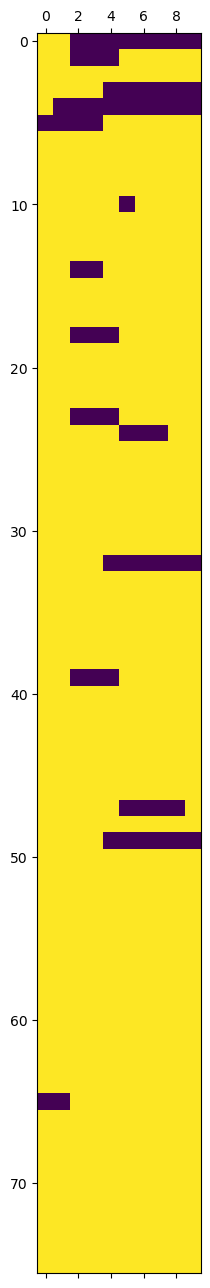

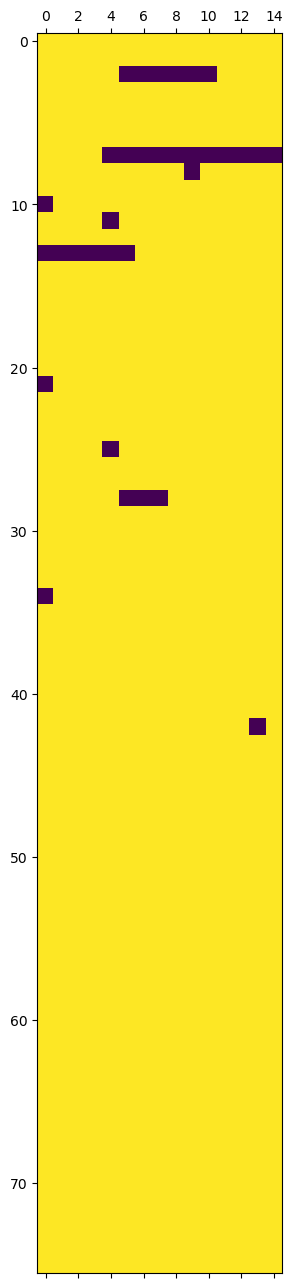

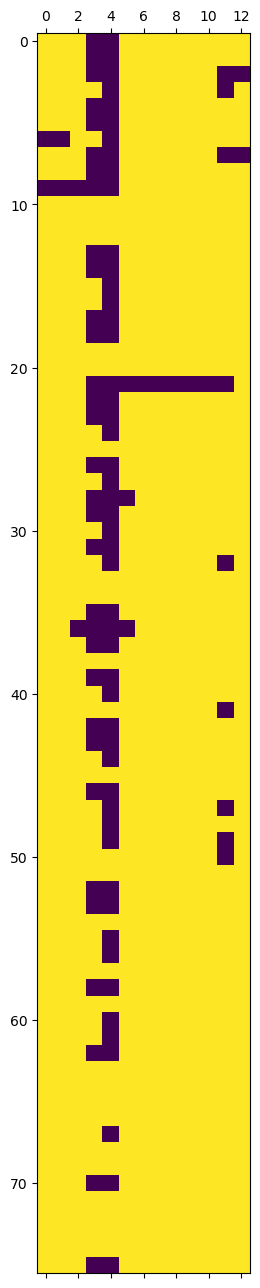

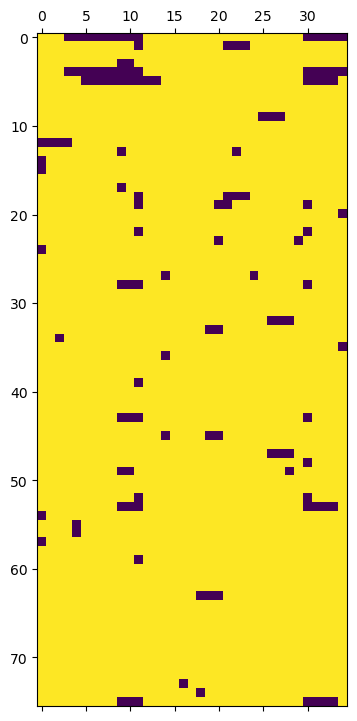

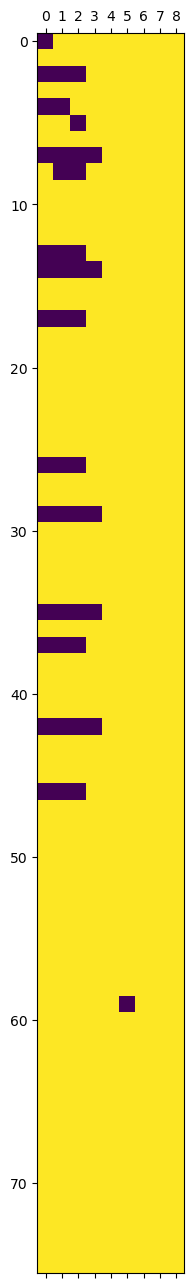

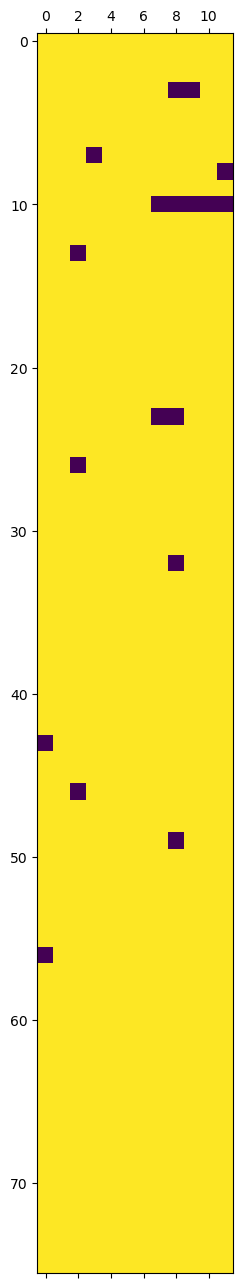

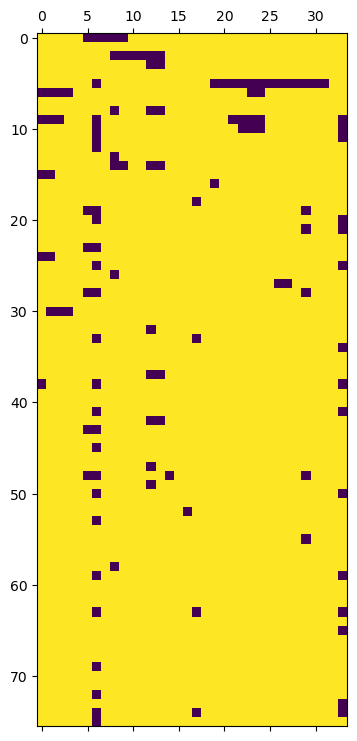

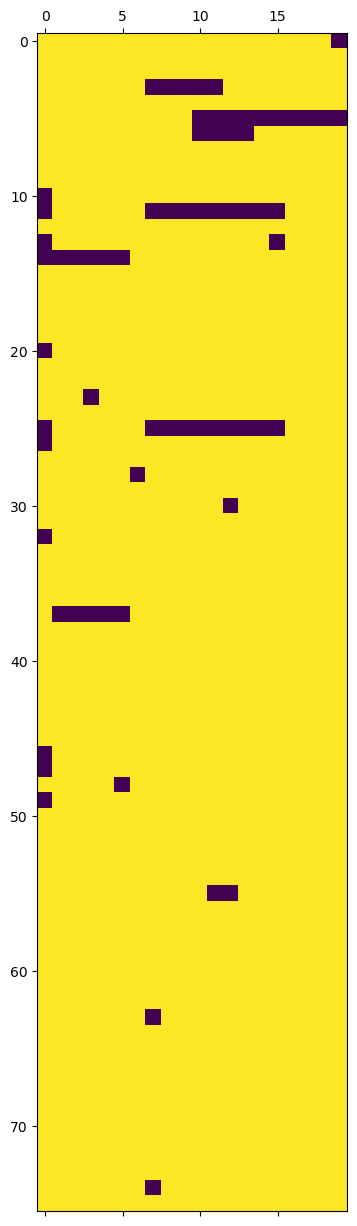

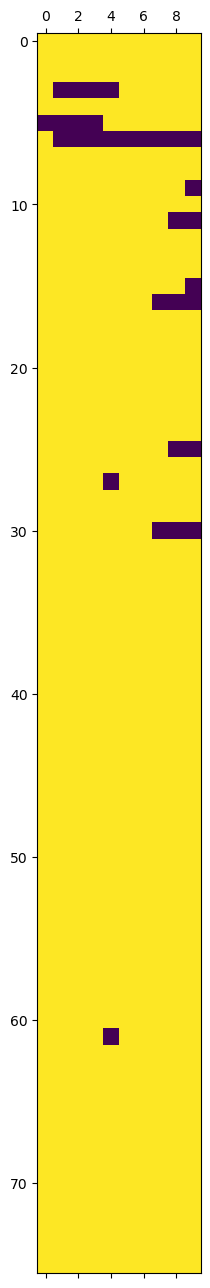

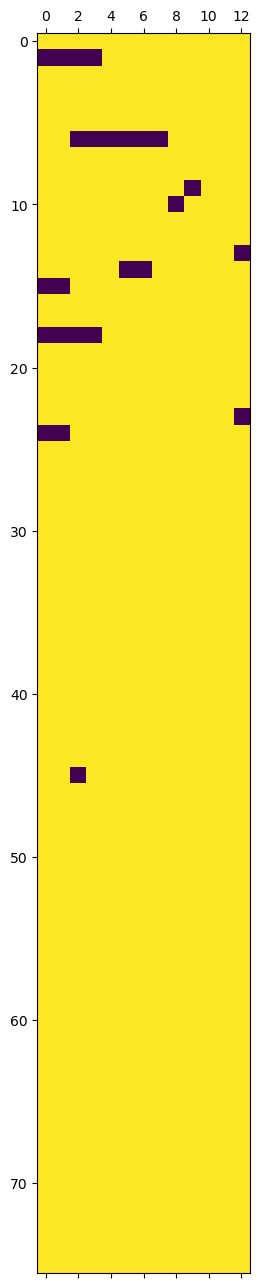

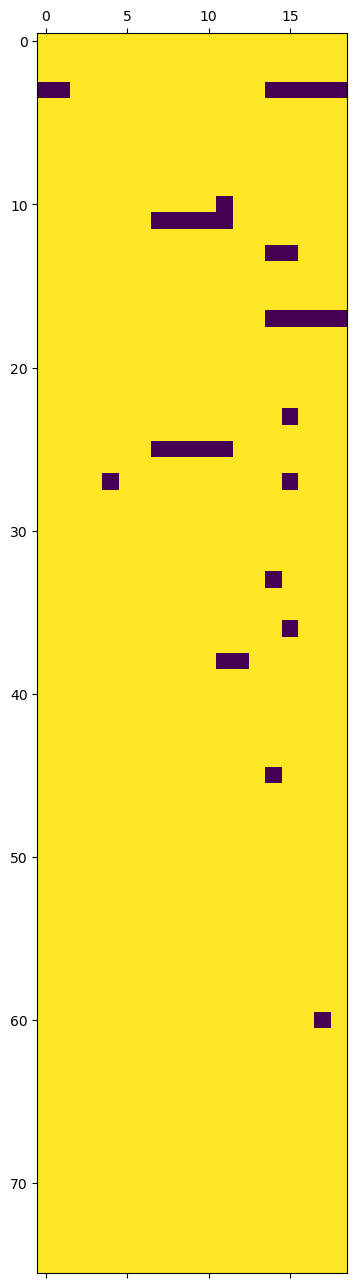

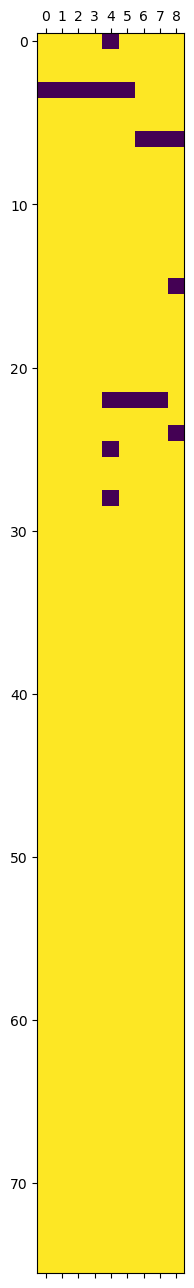

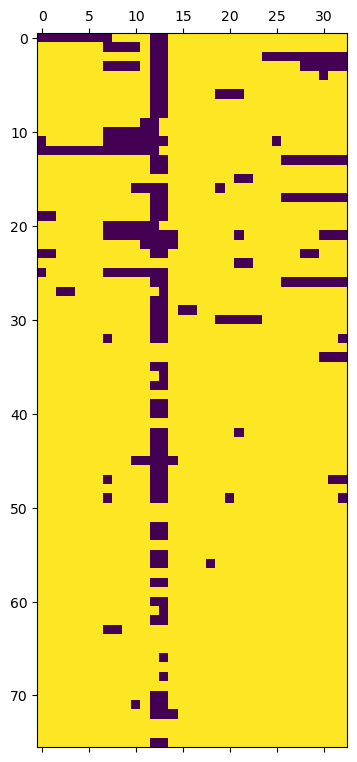

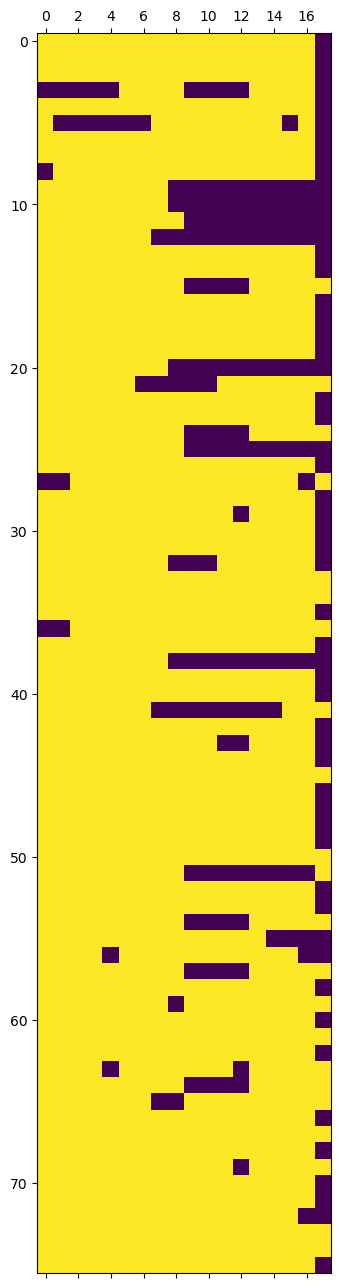

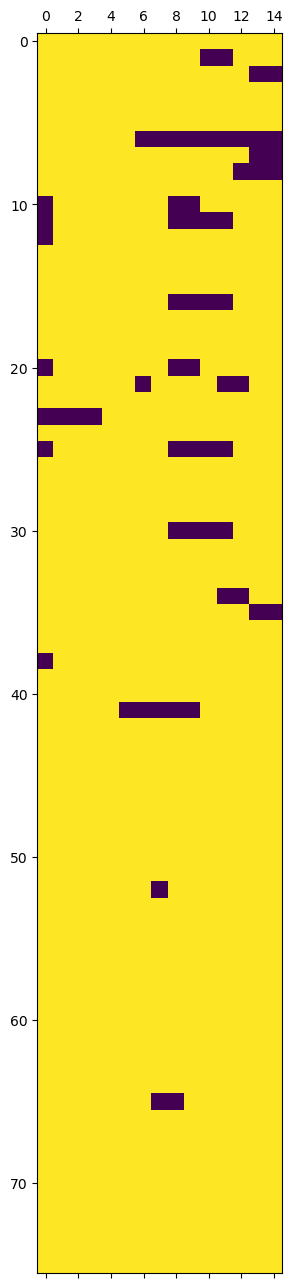

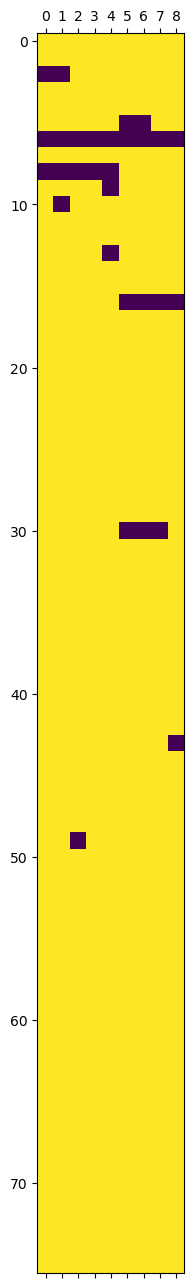

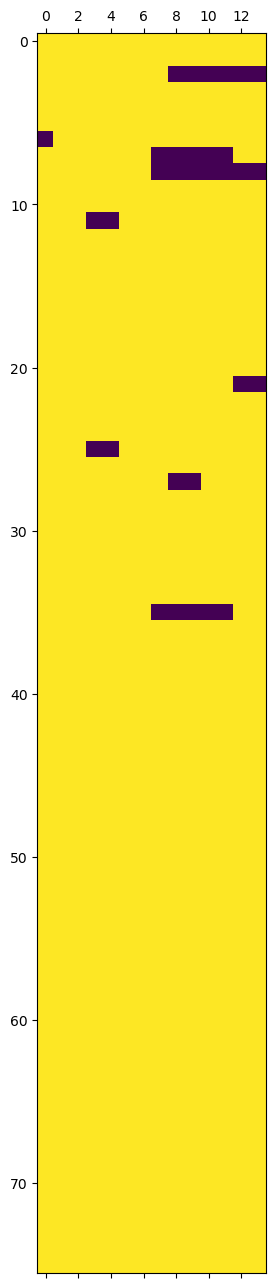

In [52]:
for i, j in cool_intervals:
    plt.matshow(matrix[:, i:j] != "-")

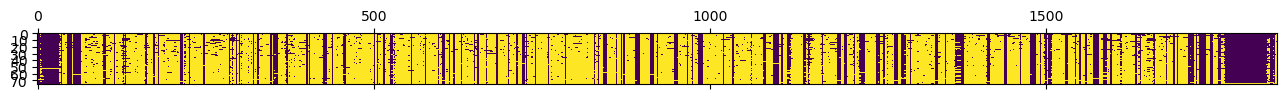

In [53]:
plt.matshow(matrix != "-")